# Timetabling Problem



The CP part of this notebook mainly draws from [this](https://developers.google.com/optimization/scheduling/job_shop?hl=en) Google guide.

The dataset used in this notebook is from the University of Brasilia and it's downloadable from [here](https://www.kaggle.com/datasets/danielefm/students-timetables-university-of-brasilia/data?select=student_timetable.csv)

**Note for running this code:** you must install the library (the cell below) and **restart the runtime**, so the `import` command would work as expected.

In [1]:
!pip install --upgrade --user ortools

In [2]:
# Importing necessary libraries
import pandas as pd
import random
import collections
import time
from ortools.sat.python import cp_model
import warnings
warnings.filterwarnings('ignore')

The goal of this analysis is to set for each course two time-slots in a particular room following some specific constraints.

Data Preprocessing:
In the initial stage of data preprocessing, courses associated with rooms labeled "Missing info" were excluded from the dataset. This decision was based on the assumption that such courses do not take place within the university, making them irrelevant for the timetabling process.

Furthermore, the analysis concentrated exclusively on rooms designated with the identifier "SALA." By isolating rooms with this specific identifier, the preprocessing step intended to prevent the matching of courses that inherently require designated rooms with generic or unsuitable alternatives.

Throughout the whole analysis we assume that every course has 2 weekly meetings of 2 hours each (1 slot per lecture, 2 slots per course).

Lastly, we isolated 10000 observation to reduce the computational time of our experiment.

In [3]:
df = pd.read_csv('student_timetable.csv', sep=';')
df = df[df.room_address != 'Missing info']
df = df[df.room_address.str.startswith('SALA')]
df = df[10000:20000]

## SEMESTER 1

In [4]:
start_1 = time.time()
semester_1 = df[df['year_semester'] == 20191]

students = semester_1['student_id'].unique()
classes = semester_1['room_address'].unique()
courses = semester_1['course'].unique()
n_courses_1 = len(courses)
slots = ['Monday 8-10', 'Monday 10-12', 'Monday 12-14', 'Monday 14-16', 'Monday 16-18',
         'Tuesday 8-10', 'Tuesday 10-12', 'Tuesday 12-14', 'Tuesday 14-16', 'Tuesday 16-18',
         'Wednesday 8-10', 'Wednesday 10-12', 'Wednesday 12-14', 'Wednesday 14-16', 'Wednesday 16-18',
         'Thursday 8-10', 'Thursday 10-12', 'Thursday 12-14', 'Thursday 14-16', 'Thursday 16-18',
         'Friday 8-10', 'Friday 10-12', 'Friday 12-14', 'Friday 14-16', 'Friday 16-18']

timetable = pd.DataFrame(columns=classes, index=slots)
semester_1['course_ind'] = 0
# creating new variable to keep the indices of each course
for ind in range(len(courses)):
    semester_1['course_ind'].iloc[semester_1['course'] == courses[ind]] = ind


Every student can have only one lesson for time-slot, so there are some courses that necessarly have to be in different timeslots.

A dictionary is created to keep track of these conflicts for each course:

In [5]:
def check_no_course(a, course): # return the list a without the value 'course' inside
    final = []
    for elem in a:
        if elem != course:
            final.append(elem)
    return final

course_indices = semester_1['course_ind'].unique()
conflict_dict = {}

for course in course_indices:
    temp = semester_1[semester_1['course_ind'] == course]
    for student in temp['student_id'].unique():
        if course not in conflict_dict.keys():
            other_courses = list(semester_1['course_ind'][semester_1['student_id'] == student].unique())
            conflict_dict[course] = check_no_course(other_courses, course)
        else:
            other_courses = list(semester_1['course_ind'][semester_1['student_id'] == student].unique())
            conflict_dict[course] = conflict_dict[course] + check_no_course(other_courses, course)

for j in conflict_dict:
    conflict_dict[j] = list(set(conflict_dict[j]))

Creating and using a CP solver from the OR-Tools library a solution is found:

In [6]:
# Main code for solving the timetable problem
timetable_s1 = pd.DataFrame(columns = slots, index = range(len(classes)))
rooms = []
random_room = 0

# Problem data
lessons_data = []
for ind1 in range(len(courses)):
    room_assignments = []
    for ind2 in range(2): # 4 hours per week for lesson
        random_room = random.sample(range(len(classes)), 1)[0]
        room_assignments.append((random_room, 1))

    lessons_data.append(room_assignments)


classes_count = 1 + max(task[0] for lesson in lessons_data for task in lesson)

all_classes = range(classes_count)

horizon = 25


# create the model
model = cp_model.CpModel()

# namedtuple to store information about created variables
number_type = collections.namedtuple('number_type', 'start end interval')
# namedtuple to manipulate solution information
assigned_number_type = collections.namedtuple('assigned_number_type',
                                            'start lesson index duration')

# creates lesson intervals and add to the corresponding classes lists
all_numbers = {}
class_to_interval = collections.defaultdict(list)

for lesson_id, lesson in enumerate(lessons_data):
    for number_id, number in enumerate(lesson):
        classs = number[0]
        duration = number[1]
        suffix = '_%i_%i' % (lesson_id, number_id)
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                            'interval' + suffix)
        all_numbers[lesson_id, number_id] = number_type(start=start_var,
                                                end=end_var,
                                                interval=interval_var)
        class_to_interval[classs].append(interval_var)

# create and add disjunctive constraints
for classs in all_classes:
    model.AddNoOverlap(class_to_interval[classs])


# add precedence constraints -> precedences between lessons
for lesson_id, lesson in enumerate(lessons_data):
    for i in conflict_dict[lesson_id]:
        model.Add(all_numbers[lesson_id, 0].start != all_numbers[i, 0].start)
    for number_id in range(len(lesson) - 1):
        model.Add(all_numbers[lesson_id, number_id + 1].start >= all_numbers[lesson_id, number_id].end)


# no conflicts constraint
for elem in conflict_dict:
    for i in conflict_dict[elem]:
        model.Add(all_numbers[elem, 0].start != all_numbers[i, 0].start)
        model.Add(all_numbers[elem, 0].start != all_numbers[i, 1].start)
        model.Add(all_numbers[elem, 1].start != all_numbers[i, 0].start)
        model.Add(all_numbers[elem, 1].start != all_numbers[i, 1].start)


# creates the solver and solve
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL:
    # create one list of assigned numbers per class
    assigned_lessons = collections.defaultdict(list)
    for lesson_id, lesson in enumerate(lessons_data):
        for number_id, number in enumerate(lesson):
            classs = number[0]
            assigned_lessons[classs].append(
                assigned_number_type(start=solver.Value(
                    all_numbers[lesson_id, number_id].start),
                                    lesson=lesson_id,
                                    index=number_id,
                                    duration=number[1]))


    for classs in all_classes:
        # sort by starting time
        assigned_lessons[classs].sort()
        row = []
        for assigned_number in assigned_lessons[classs]:
            row.append([assigned_number.lesson, assigned_number.start])

            start = assigned_number.start
            duration = assigned_number.duration

        for elem in row:
            timetable_s1.iloc[classs, elem[1]] = elem[0]



    print('  - conflicts: %i' % solver.NumConflicts())
    print('  - wall time: %f s' % solver.WallTime())
else:
    print('No solution found.')



  - conflicts: 0
  - wall time: 0.700986 s


In [7]:
timetable_s1 = timetable_s1.transpose()

From the index the real name of the classes is returned:

In [8]:
timetable_s1.columns = classes
for i in range(len(timetable_s1)):
  for j in range(len(classes)):
    if not pd.isna(timetable_s1.iloc[i,j]):
      timetable_s1.iloc[i,j] = courses[timetable_s1.iloc[i,j]]
    else:
      timetable_s1.iloc[i,j] = '*'

A function that gives a value to each timetable based on some soft constraints as having courses of two adjacent time slots and having free afternoons

In [9]:
def check_soft(tt):
  val = 0
  for i in range(25):
    for j in range(len(classes)):
      if i % 5 != 4:
        if tt.iloc[i,j] == tt.iloc[i+1,j]: # preferrably having courses of two adjacent time slots (not on different days)
          val += 0.1
      if i % 5 == 4 or i % 5 == 3: # preferrably having free afternoons
        if tt.iloc[i,j] == '*':
          val += 1
  return val

Permutating 500 times the rows of the dataset the timetable with a higher value for soft constraints it is chosen

In [10]:
new_tt = timetable_s1.copy() # working timetable

final_tt1 = timetable_s1.copy() # final timetable
current = check_soft(final_tt1) # value of the final

for tts in range(100):
  new = random.sample(range(25), 25) # random permutation
  for i in range(25):
    new_tt.iloc[i] = timetable_s1.iloc[new[i]]
  value = check_soft(new_tt) # checking the value of the permutation
  if value > current: # saving it if it's better
    final_tt1 = new_tt.copy()
    current = value

end_1 = time.time()
final_tt1.iloc[:,0:4]

,SALA PJC BT 132,SALA PAT AT 021,SALA PJC BT 100,SALA BSA B2 34/10
Monday 8-10,*,*,*,Heat Transport And Pasta
Monday 10-12,Economy From Brazil Contemporary,*,*,Aesthetics And Art Of Philosophy
Monday 12-14,*,Philosophy Of Law,*,Text Lab 2
Monday 14-16,Computer Security,*,*,*
Monday 16-18,General Economic History,*,"Society, Culture And Politics In The Americas",*
Tuesday 8-10,Plant Physiology,*,Soil Fertility And Fertilization,Forest Harvesting And Transport
Tuesday 10-12,Management Technologies And Management In Health,*,The Physiotherapy Practice Based On Problems,*
Tuesday 12-14,*,*,In Internship 1 Social Services,Metabolism And Development Plant
Tuesday 14-16,*,Palaeoceanography And Paleoclimate,*,Applied Thermodynamics
Tuesday 16-18,*,Applied Thermodynamics,Trauma And Prosthesis Oral And Maxillofacial,*


## SEMESTER 2

Doing the same thing for semester 2

In [11]:
start_2 = time.time()
semester_2 = df[df['year_semester'] == 20192]

students = semester_2['student_id'].unique()
classes = semester_2['room_address'].unique()
courses = semester_2['course'].unique()
n_courses_2 = len(courses)


semester_2['course_ind'] = 0
for ind in range(len(courses)):
    semester_2['course_ind'].iloc[semester_2['course'] == courses[ind]] = ind


In [12]:
course_indices = semester_2['course_ind'].unique()
conflict_dict = {}
for course in course_indices:
    temp = semester_2[semester_2['course_ind'] == course]
    for student in temp['student_id'].unique():
        if course not in conflict_dict.keys():
            other_courses = list(semester_2['course_ind'][semester_2['student_id'] == student].unique())
            conflict_dict[course] = check_no_course(other_courses, course)
        else:
            other_courses = list(semester_2['course_ind'][semester_2['student_id'] == student].unique())
            conflict_dict[course] = conflict_dict[course] + check_no_course(other_courses, course)

for j in conflict_dict:
    conflict_dict[j] = list(set(conflict_dict[j]))


In [13]:
timetable_s2 = pd.DataFrame(columns = slots, index = range(len(classes)))
rooms = []
random_room = 0

# Problem data
lessons_data = []
for ind1 in range(len(courses)):
    room_assignments = []
    for ind2 in range(2): # 4 hours per week for lesson
        random_room = random.sample(range(len(classes)), 1)[0]
        room_assignments.append((random_room, 1))

    lessons_data.append(room_assignments)


classes_count = 1 + max(number[0] for lesson in lessons_data for number in lesson)

all_classes = range(classes_count)

horizon = 25


# create the model
model = cp_model.CpModel()

# namedtuple to store information about created variables
number_type = collections.namedtuple('number_type', 'start end interval')
# namedtuple to manipulate solution information
assigned_number_type = collections.namedtuple('assigned_number_type',
                                            'start lesson index duration')

# creates lesson intervals and add to the corresponding classes lists
all_numbers = {}
class_to_interval = collections.defaultdict(list)

for lesson_id, lesson in enumerate(lessons_data):
    for number_id, number in enumerate(lesson):
        classs = number[0]
        duration = number[1]
        suffix = '_%i_%i' % (lesson_id, number_id)
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                            'interval' + suffix)
        all_numbers[lesson_id, number_id] = number_type(start=start_var,
                                                end=end_var,
                                                interval=interval_var)
        class_to_interval[classs].append(interval_var)

# create and add disjunctive constraints
for classs in all_classes:
    model.AddNoOverlap(class_to_interval[classs])


# add precedence constraints -> precedences between lessons
for lesson_id, lesson in enumerate(lessons_data):
    for i in conflict_dict[lesson_id]:
        model.Add(all_numbers[lesson_id, 0].start != all_numbers[i, 0].start)
    for number_id in range(len(lesson) - 1):
        model.Add(all_numbers[lesson_id, number_id + 1].start >= all_numbers[lesson_id, number_id].end)


# no conflicts constraint
for elem in conflict_dict:
    for i in conflict_dict[elem]:
        model.Add(all_numbers[elem, 0].start != all_numbers[i, 0].start)
        model.Add(all_numbers[elem, 0].start != all_numbers[i, 1].start)
        model.Add(all_numbers[elem, 1].start != all_numbers[i, 0].start)
        model.Add(all_numbers[elem, 1].start != all_numbers[i, 1].start)


# creates the solver and solve
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL:
    # create one list of assigned numbers per class
    assigned_lessons = collections.defaultdict(list)
    for lesson_id, lesson in enumerate(lessons_data):
        for number_id, number in enumerate(lesson):
            classs = number[0]
            assigned_lessons[classs].append(
                assigned_number_type(start=solver.Value(
                    all_numbers[lesson_id, number_id].start),
                                    lesson=lesson_id,
                                    index=number_id,
                                    duration=number[1]))


    for classs in all_classes:
        # sort by starting time
        assigned_lessons[classs].sort()
        row = []
        for assigned_number in assigned_lessons[classs]:
            row.append([assigned_number.lesson, assigned_number.start])

            start = assigned_number.start
            duration = assigned_number.duration
        for elem in row:
            timetable_s2.iloc[classs, elem[1]] = elem[0]


    print('  - conflicts: %i' % solver.NumConflicts())
    print('  - wall time: %f s' % solver.WallTime())
else:
    print('No solution found.')



  - conflicts: 1
  - wall time: 0.617696 s


In [14]:
timetable_s2 = timetable_s2.transpose()

In [15]:
timetable_s2.columns = classes
for i in range(len(timetable_s2)):
  for j in range(len(classes)):
    if not pd.isna(timetable_s2.iloc[i,j]):
      timetable_s2.iloc[i,j] = courses[timetable_s2.iloc[i,j]]
    else:
      timetable_s2.iloc[i,j] = '*'

In [16]:
new_tt = timetable_s2.copy() # working timetable

final_tt2 = timetable_s2.copy() # final timetable
current = check_soft(final_tt2) # value of the final

for tts in range(100):
  new = random.sample(range(25), 25) # random permutation
  for i in range(25):
    new_tt.iloc[i] = timetable_s2.iloc[new[i]]
  value = check_soft(new_tt) # checking the value of the permutation
  if value > current: # saving it if it's better
    final_tt2 = new_tt.copy()
    current = value

end_2 = time.time()
final_tt2.iloc[:,0:4]

,SALA UAC A1 42/13,SALA UAC AT 48/43,SALA UAC AT 48/40,SALA UAC A1 48/23
Monday 8-10,*,*,Modern History 1,*
Monday 10-12,Pharmacology 1,Analyzes Methodologies Texts In Spanish,*,Development Applications
Monday 12-14,*,Philosophy Philosophy Of Teaching,*,*
Monday 14-16,*,*,*,*
Monday 16-18,*,*,*,*
Tuesday 8-10,Physical Geography 2: Meteorology And Climatology,Geological Technical Drawing,*,Environmental Benefit Analysis Cost Of Projects
Tuesday 10-12,*,*,*,Psychology Of Organizations
Tuesday 12-14,Psychological Development And Education,Social And Environmental Responsibility Manage...,*,*
Tuesday 14-16,*,Creativity And Intuition In Knowledge Of Produ...,*,*
Tuesday 16-18,*,Chinese Language 1,Pharmacology 2,*


Unique courses in the first semester:

In [17]:
n_courses_1

1123

Computational time for first semester

In [18]:
end_1-start_1

8.959065914154053

Unique courses in the second semester:

In [19]:
n_courses_2

976

Computational time for second semester:

In [20]:
end_2-start_2

8.330932855606079

## STUDENT FUNCTION

Function that returns the timetable of each student for semester 1 or 2

In [21]:
def timetable(student_id, semester):
    basic_tt = pd.DataFrame(columns = ['Monday','Tuesday','Wednesday','Thursday','Friday'], index = ['8-10','10-12','12-14','14-16','16-18'])
    if semester == 1:
        df_stu = semester_1[semester_1['student_id'] == student_id]
        courses_to_follow = df_stu['course'].unique()
        for i in range(len(slots)):
            for j in range(len(classes)):
                course = final_tt1.iloc[i,j]
                if course in courses_to_follow:
                    values = slots[i].split()
                    basic_tt[values[0]][values[1]] = course, classes[j]
    else:
        df_stu = semester_2[semester_2['student_id'] == student_id]
        courses_to_follow = df_stu['course'].unique()
        for i in range(len(slots)):
            for j in range(len(classes)):
                course = final_tt2.iloc[i,j]
                if course in courses_to_follow:
                    values = slots[i].split()
                    basic_tt[values[0]][values[1]] = course, classes[j]
    basic_tt.fillna('*', inplace=True)
    return basic_tt

Example with a random student:

In [22]:
pos = random.sample(range(len(df)),1)
random_student = int(df.iloc[pos]['student_id'])

In [23]:
timetable(random_student, 1)

,Monday,Tuesday,Wednesday,Thursday,Friday
8-10,*,"(Commercial Law, SALA BSA SUL BT 11/10)",*,*,"(Commercial Law, SALA AT 127/7)"
10-12,*,*,*,*,*
12-14,*,*,*,*,*
14-16,*,"(Costs, SALA FA A1 08 ...",*,"(General Accounting 3, SALA PAT AT 132 ...","(General Accounting 3, SALA PAT AT 092 ..."
16-18,*,*,"(Costs, SALA FA A1 15 ...",*,*


In [24]:
timetable(random_student, 2)

,Monday,Tuesday,Wednesday,Thursday,Friday
8-10,*,*,*,*,*
10-12,*,*,*,*,*
12-14,*,"(Economic And Financial Analysis 1, SALA PJC B...",*,*,*
14-16,*,*,*,*,*
16-18,"(Accounting Information Systems, SALA BSA NORT...",*,"(Accounting Information Systems, SALA PJC BT 1...",*,"(Economic And Financial Analysis 1, SALA PJC B..."


## ASSESSMENT OF RESULTS

Checking how many rooms are occupied inside the university for each time-slot.

In [25]:
busyrooms_s1_before = []
busyrooms_s2_before = []
busyrooms_s1_after = []
busyrooms_s2_after = []

for i in range(25):
  busyrooms_s1_after.append(sum(final_tt1.iloc[i] != '*')/len(classes)*100)
  busyrooms_s2_after.append(sum(final_tt2.iloc[i] != '*')/len(classes)*100)
  busyrooms_s1_before.append(sum(timetable_s1.iloc[i] != '*')/len(classes)*100)
  busyrooms_s2_before.append(sum(timetable_s2.iloc[i] != '*')/len(classes)*100)


Percentual of room occupation in the university in the first semester before the permutation:

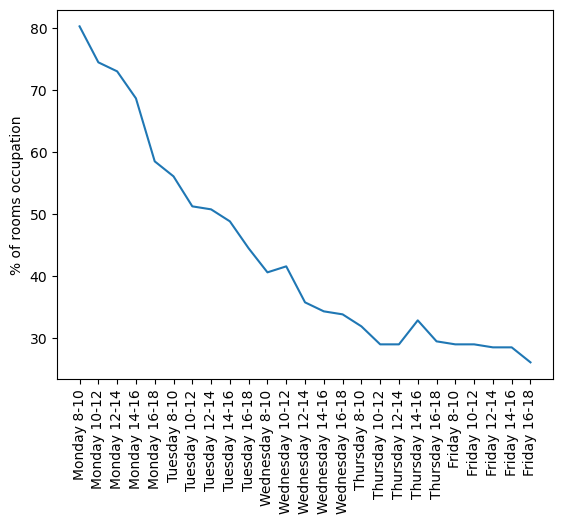

In [26]:
import matplotlib.pyplot as plt

plt.plot(slots,busyrooms_s1_before)
plt.xticks(fontsize = 10, rotation = 90)
plt.ylabel("% of rooms occupation")
plt.show()

Percentual of room occupation in the university in the first semester after the permutation:

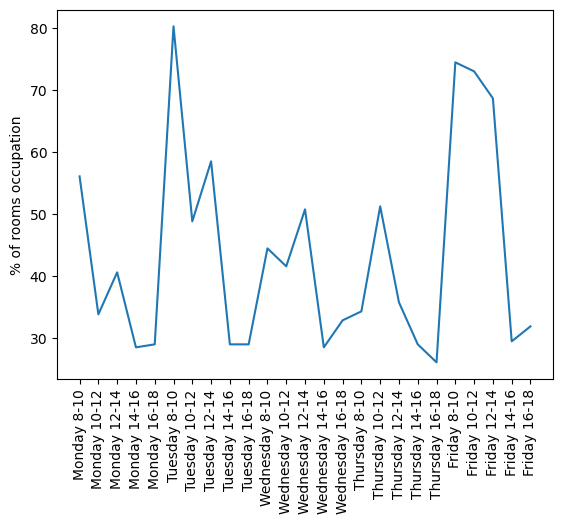

In [27]:
plt.plot(slots,busyrooms_s1_after)
plt.xticks(fontsize = 10, rotation = 90)
plt.ylabel("% of rooms occupation")
plt.show()

Percentual of room occupation in the university in the second semester before the permutation:

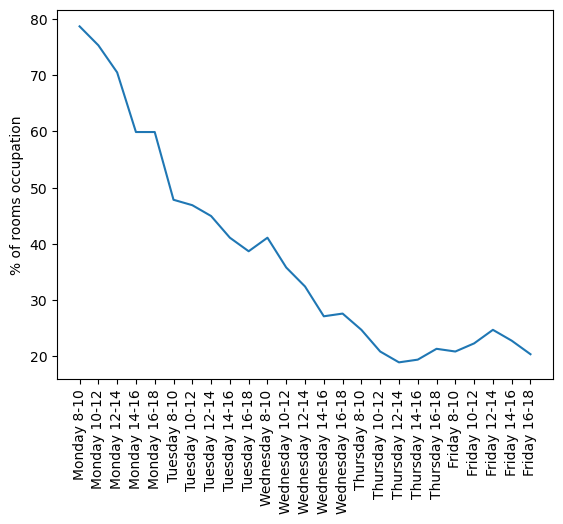

In [28]:
plt.plot(slots,busyrooms_s2_before)
plt.xticks(fontsize = 10, rotation = 90)
plt.ylabel("% of rooms occupation")
plt.show()

Percentual of room occupation in the university in the second semester after the permutation:

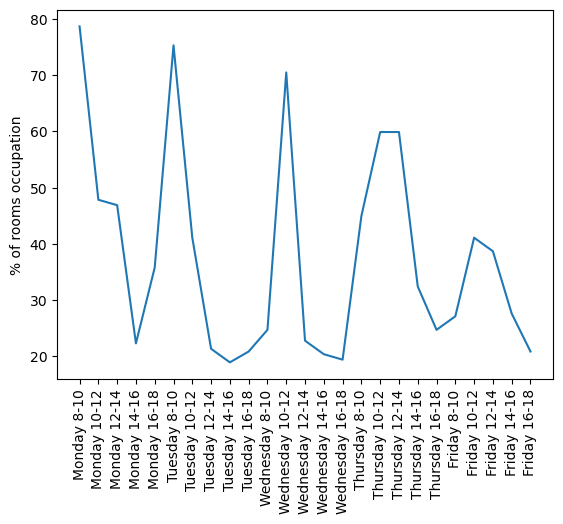

In [29]:
plt.plot(slots,busyrooms_s2_after)
plt.xticks(fontsize = 10, rotation = 90)
plt.ylabel("% of rooms occupation")
plt.show()